In [1]:
import neural_priors

In [2]:
from neural_priors.utils.plotting import plot_prf_predictions
from neural_priors.utils.data import Subject, get_all_subject_ids, get_all_behavioral_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
from scipy import stats, odr
from braincoder.models import LogGaussianPRF, GaussianPRF

In [3]:
plt.rcParams['legend.frameon'] = False
np.set_printoptions(linewidth=140)
pd.set_option('display.width', 170) # 80
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 70)

In [4]:
bids_folder = '/data/ds-neuralpriors'

2024-06-04 14:54:21.591341: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


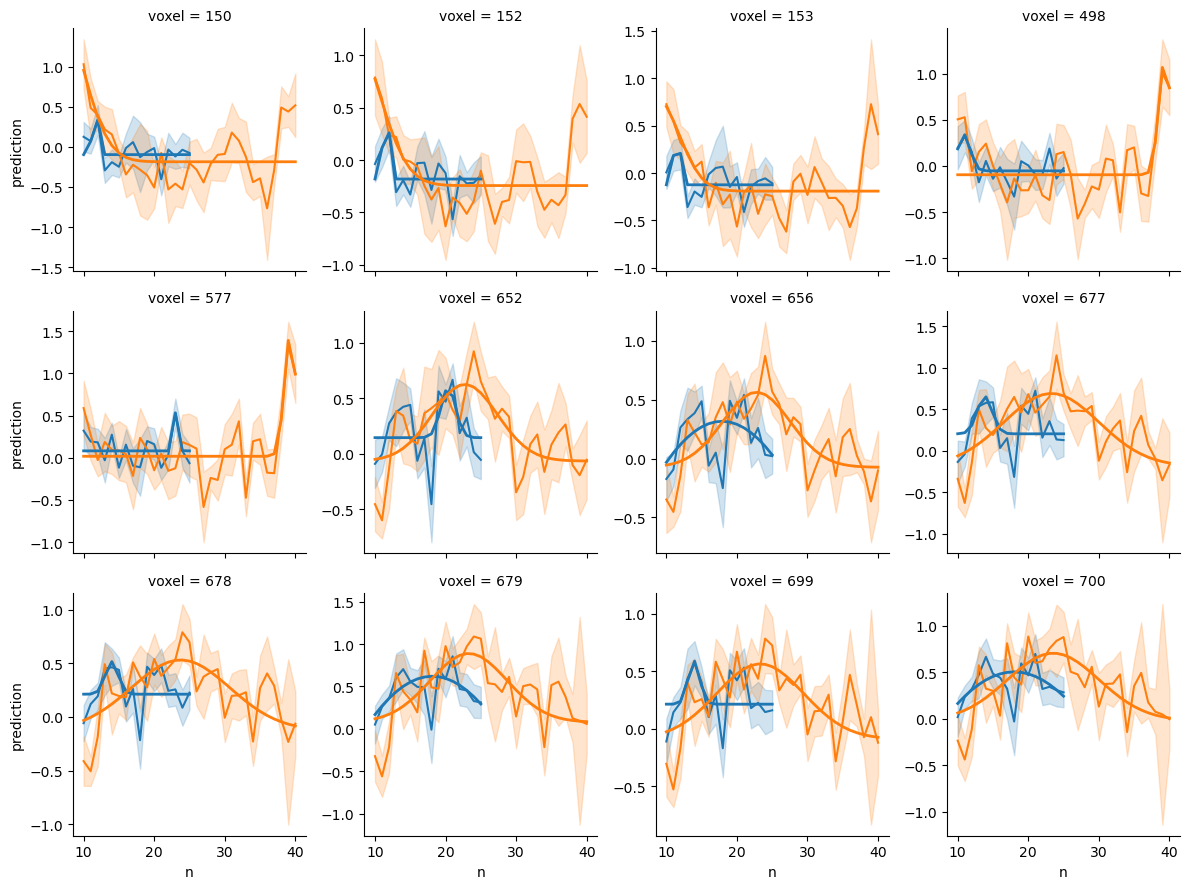

In [5]:
plot_prf_predictions('25', bids_folder=bids_folder, gaussian=True)

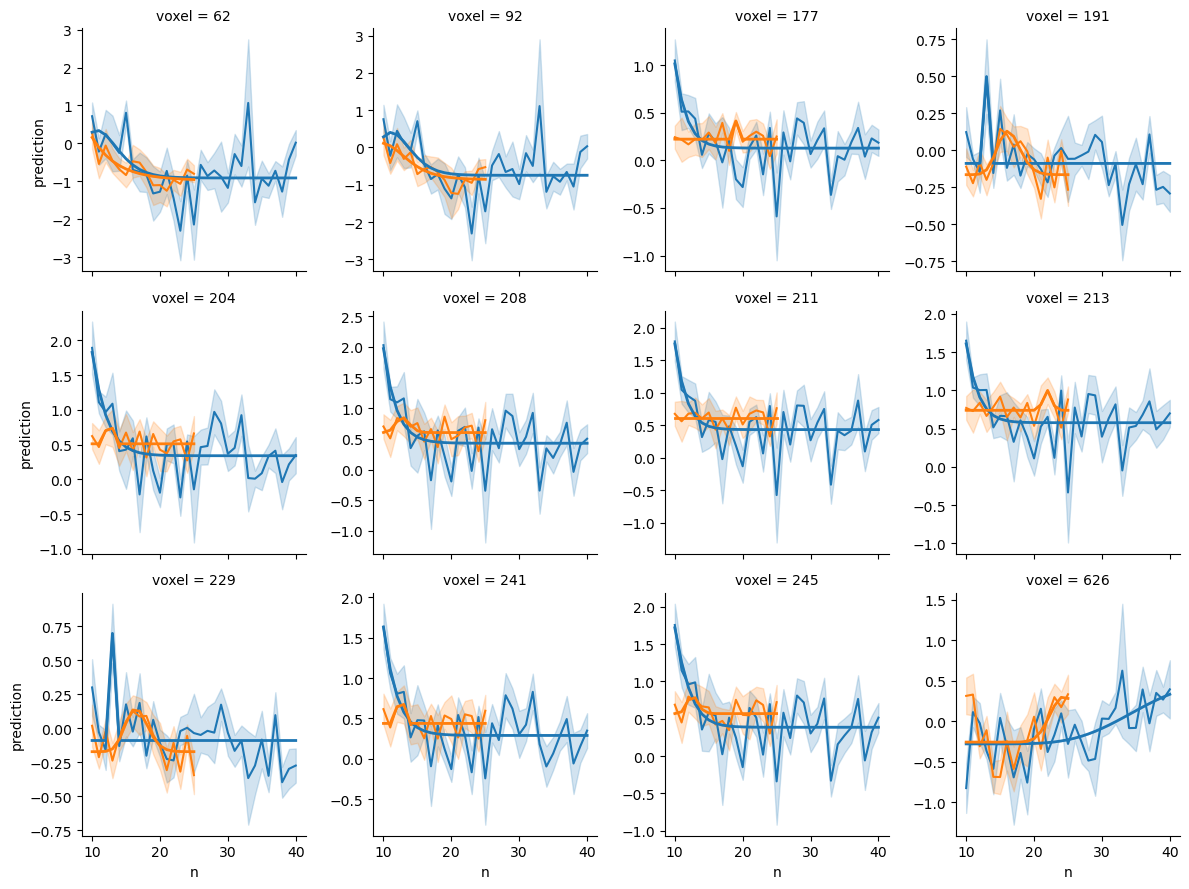

In [6]:
plot_prf_predictions('32', bids_folder=bids_folder, gaussian=False)

In [7]:
behavior = get_all_behavioral_data(bids_folder=bids_folder) #, subjects=[f'{i}'.rjust(2,'0') for i in range(1,23)])

In [8]:
from tqdm.contrib.itertools import product

In [9]:
load_data_via_tsv = True

if load_data_via_tsv:
    df = pd.read_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t',
                    index_col=[0, 1, 2, 3, 4, 5,],
                    dtype={'subject':str})
    df.columns.name = 'parameter'
    df.index.set_names('voxel', level=-1, inplace=True)
else:
    df = []
    keys = []
    subjects = get_all_subject_ids()
    #subjects.pop(subjects.index('11'))
    #subjects.pop(subjects.index('16'))

    for subject, range_n, session, smoothed, gaussian in product(subjects, ['wide', 'narrow', None, 'wide2'], [None], [True, False], [False, True]):
    # for subject, range_n, session, smoothed in product(subjects, ['wide', 'narrow', None], [None], [True, False]):
        try:
            sub = Subject(subject, bids_folder)
            sub_df = sub.get_prf_parameters_volume(session=session, cross_validated=False, roi='NPCr', smoothed=smoothed, range_n=range_n, gaussian=gaussian)

            if gaussian:
                sub_df = sub_df.rename(columns={'mu':'mode', 'sd':'width'})
            else:
                sub_df = sub_df.rename(columns={'fwhm':'width'})
            df.append(sub_df)
            keys.append((subject,
                        range_n if range_n is not None else 'both', session if session is not None else 'both',
                        'smoothed' if smoothed else 'unsmoothed',
                        'gaussian' if gaussian else 'lognormal'))

        except Exception as e:
            print(f'Problem with {subject}: {e}')

    df = pd.concat(df, keys=keys, names=['subject', 'range_n', 'session', 'smoothed', 'model'])
    df.to_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t')

df = df.unstack(['range_n', 'model', ]).reorder_levels(axis='columns', order=['model', 'parameter', 'range_n'])
df = df.sort_index(axis=1, level=['model'], sort_remaining=False)

In [10]:
df

model                              gaussian                                                                                                                       \
parameter                              mode                                      width                                amplitude                                    
range_n                                wide     narrow       both      wide2      wide     narrow      both     wide2      wide      narrow       both     wide2   
subject session smoothed   voxel                                                                                                                                   
01      both    smoothed   0      37.364826  21.124500  37.348385  11.517796  0.341002   0.396827  0.346775  0.906162  1.438429    0.680798   1.289311  0.729588   
                           1      33.824623   4.783791  33.821358  11.687057  0.691629   4.528500  0.667084  0.466805  0.748930    0.540905   0.723414  1.072110   
                           2      28.557991  11.896777  28.558237  15.473819  0.415108   0.934195  0.399016  1.315624  0.991627    0.328446   0.965211  0.488749   
                           3      15.576399  12.634756  15.078053  15.590551  1.232276   2.400554  1.203502  1.414796  0.484945    0.272006   0.293359  0.609456   
                           4      11.836634   8.140844  11.579211  11.840950  0.779714   0.545360  1.052765  0.820746  0.961715  153.636470   0.375336  1.067275   
...                                     ...        ...        ...        ...       ...        ...       ...       ...       ...         ...        ...       ...   
38      both    unsmoothed 697    12.484799   6.792138  10.311142  12.482238  0.664732   4.126427  2.428229  0.703325  0.524959    0.987310   0.462412  0.526505   
                           698    34.230650  15.114270  34.231560  20.379576  1.057392   0.229958  1.006889  3.538527  0.692827    0.247191   0.666601  0.418633   
                           699    30.159763  14.136518  30.157118  18.601698  0.622103   0.562273  0.629685  0.377287  0.687669    0.456858   0.692780  0.878269   
                           700    33.457390 -20.811913   5.260218  10.440446  0.410653  37.259600  1.755525  0.365949  1.304185    3.031507  29.586637  1.065640   
                           701     9.317807   3.766264   7.819368   9.402459  1.831878  31.759820  4.203909  1.932335  0.695855    3.963244   0.577808  0.725357   

model                                                                                                                                                     lognormal  \
parameter                         baseline                                      r2                                    cvr2                                     mode   
range_n                               wide    narrow      both     wide2      wide    narrow      both     wide2      wide    narrow      both     wide2       wide   
subject session smoothed   voxel                                                                                                                                      
01      both    smoothed   0     -0.130019 -0.100848 -0.096930 -0.242621  0.025210  0.020509  0.013219  0.031572 -0.010679 -0.037111 -0.013963 -0.150426  37.357880   
                           1     -0.531615 -0.537404 -0.504734 -0.641905  0.021125  0.009864  0.011212  0.036705 -0.077199 -0.060669 -0.033635 -0.112344  33.805150   
                           2     -0.533834 -0.502003 -0.494730 -0.664774  0.028490  0.019594  0.015095  0.043335 -0.078409 -0.051255 -0.040969 -0.139146  28.577208   
                           3     -0.345589 -0.334171 -0.312884 -0.462194  0.027097  0.027599  0.014951  0.070238 -0.079311 -0.021471 -0.060922 -0.090663  15.417795   
                           4     -0.108668 -0.120475 -0.110317 -0.199313  0.027147  0.013595  0.008204  0.050541 -0.054760 -0.026661 -0.040119 -0.100712  11.764568   
...                                 

In [52]:
df.xs(key=('cvr2','wide'), axis=1, level=('parameter','range_n') )

model                           gaussian  lognormal
subject session smoothed                           
01      both    smoothed   0   -0.010679  -0.010233
                           1   -0.077199  -0.077481
                           2   -0.078409  -0.078136
                           3   -0.079311  -0.083772
                           4   -0.054760  -0.054666
...                                  ...        ...
38      both    unsmoothed 697 -0.033036  -0.032694
                           698 -0.033513  -0.033612
                           699 -0.005083  -0.004766
                           700 -0.040261  -0.039634
                           701 -0.046258  -0.045499

[54654 rows x 2 columns]

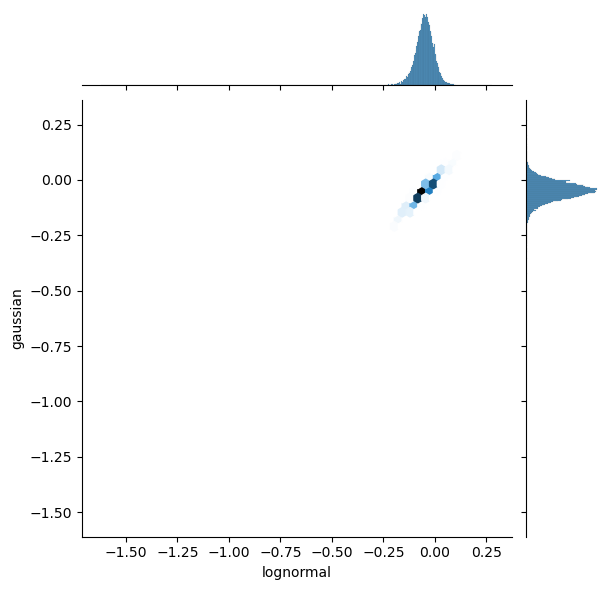

In [41]:
sns.jointplot(data=df.xs(key=('cvr2','wide'), axis=1, level=('parameter','range_n') ), x='lognormal', y='gaussian', kind='hex')

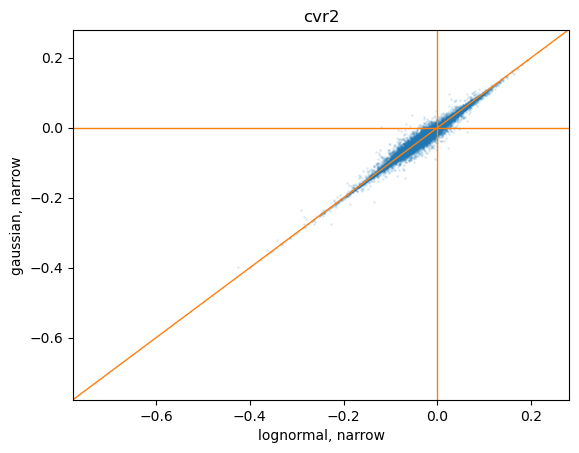

In [42]:
#sns.scatterplot(data=df.xs('cvr2', axis=1, level='parameter'), x='lognormal', y='gaussian', hue='range_n')
plt.scatter(df['lognormal', 'cvr2', 'narrow'], df['gaussian', 'cvr2', 'narrow'], s=1, alpha=.1);
plt.xlabel('lognormal, narrow'); plt.ylabel('gaussian, narrow')
plt.title('cvr2')
plt.axline((0,0), slope=1, c='C1', lw=1)
plt.axhline(0, c='C1', lw=1)
plt.axvline(0, c='C1', lw=1)

<Axes: xlabel="('lognormal', 'width', 'wide')", ylabel='Count'>

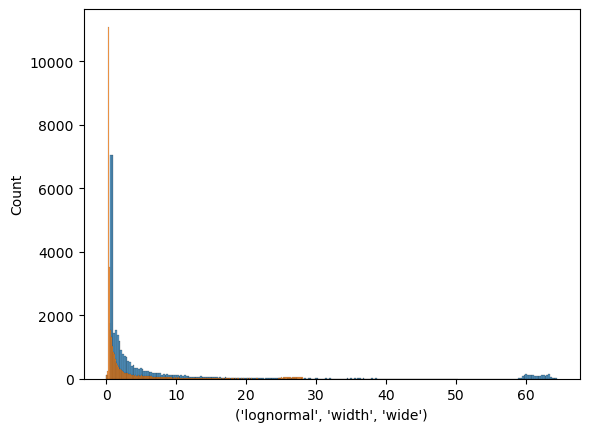

In [24]:
sns.histplot(df[('lognormal', 'width', 'wide')])
sns.histplot(df[('gaussian', 'width', 'wide')])

<Axes: xlabel="('lognormal', 'width', 'narrow')", ylabel='Count'>

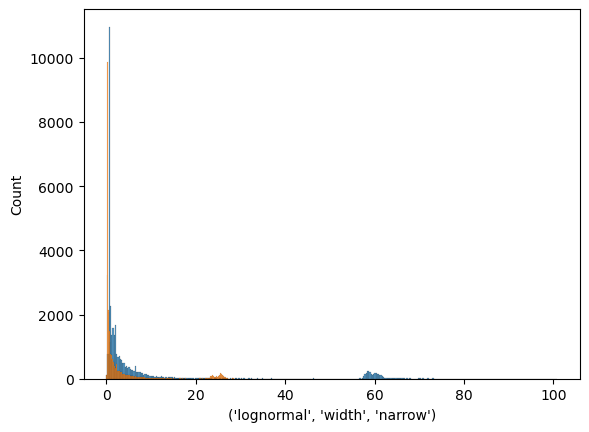

In [25]:
sns.histplot(df[('lognormal', 'width', 'narrow')])
sns.histplot(df[('gaussian', 'width', 'narrow')])

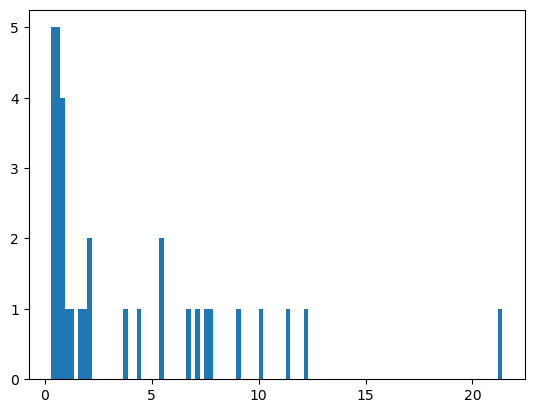

In [26]:
# doing good with lognormal but not with gaussian 
# and have (lognormal) mode in the range
mask = (df[('lognormal', 'cvr2', 'narrow')] > 0.01) & (df[('gaussian', 'cvr2', 'narrow')] < 0.0)
mask &= (df[('lognormal', 'mode', 'narrow')] >= 12 ) & (df[('lognormal', 'mode', 'narrow')] <= 23 )
plt.hist( df[mask][('gaussian','amplitude','narrow')], bins=100);

In [27]:
df[mask][('gaussian','amplitude','narrow')].shape

(33,)

In [28]:
np.mean( df[mask][('gaussian','amplitude','narrow')].values <= 0.001 )

0.0

In [29]:
df[mask]

model                             gaussian                                                                                                                          \
parameter                             mode                                       width                                  amplitude                                    
range_n                               wide     narrow       both      wide2       wide     narrow       both      wide2      wide     narrow      both       wide2   
subject session smoothed                                                                                                                                             
02      both    unsmoothed 151   20.038164  15.463536  16.712923  20.022318   1.197472   4.422785   2.595067   1.653312  0.463057   0.933126  0.277426    0.529784   
                           293   33.822193  17.847488  17.889956  19.279829   0.640517   1.366629   1.350904   0.338500  1.184137   0.582934  0.503174    0.469074   
                           732   36.543709  17.147043  18.769499  18.992828   0.331481   3.186252   0.300199   0.186224  1.687732   0.626912  0.897680    0.529820   
03      both    unsmoothed 184   18.439167  19.695675  25.935795  18.459021   0.350121  26.027653  26.262619   0.290948  1.175210  10.119495  2.398844    1.893283   
04      both    smoothed   162    6.432660  14.216002  14.290532  14.530349  27.504847   3.211273   3.218822   3.340203  0.654663   0.288783  0.275683    0.259456   
                           186   13.982001  14.477395  14.724297  10.941178  26.545568   3.310138   3.813331   0.240212  0.772967   0.334871  0.249597    0.313544   
                unsmoothed 189   13.020648  13.968487  13.274189  13.091984   4.826857  24.681971   4.404119   5.063888  0.566381   6.636905  0.459365    0.625349   
                           525    9.893428  13.527761  11.518045  10.071891   3.802100   7.980956   4.243341   3.493890  0.877722   0.693020  0.487027    0.828018   
05      both    unsmoothed 211   17.547462  18.051014  17.117384  20.037357   0.388718  23.332409   3.092718  26.596649  1.737749  12.300082  0.541063   13.241249   
06      both    smoothed   102   28.779570  16.867018  28.823301  23.560022   0.304985  23.734144   0.297517   0.316177  0.596066   7.520225  0.534282    0.806619   
                           103   28.760439  16.788857  14.427707  23.592306   0.311533  23.574837   0.389200   0.315772  0.397035   5.541859  0.415745    0.562222   
                           134   29.393579  17.070765  14.168305   8.082399   0.389119  23.397524   0.876252   0.520955  0.341597   3.819364  0.149112  196.153732   
                unsmoothed 73    11.468377  17.708937  18.101097  11.470853   0.339828  24.052959   0.272216   0.325099  1.440160   9.094346  0.356120    1.580413   
08      both    unsmoothed 224   32.502083  20.015524  32.502281   7.800323   0.328881  26.811657   0.337260   0.837889  1.111281   5.382812  1.013808    1.407314   
                           389   38.973103  22.626806  14.460150  19.386181   0.245221   0.268356   0.358963   0.346138  0.813416   2.003691  1.009038    1.555621   
14      both    unsmoothed 45    38.061901  19.392570  15.692360  16.147202   0.259232   0.279115   0.321781   0.450199  1.055712   1.830248  0.857528    0.657499   
16      both    unsmoothed 195   18.115057  14.076628  11.275635  18.103333   0.269483   0.255026   0.631292   0.255186  0.837664   1.258074  0.645853    0.826277   
18      both    unsmoothed 690   20.520569  16.564611  19.637484  20.124472   0.364932   4.708615   0.354694   0.743976  1.595737   0.834019  0.729579    0.690645   
                           707   24.330648  17.685728  18.013056  24.417833   0.732419  15.832547   3.443872   0.808138  0.746381   7.159544  0.340687    0.670634   
20      both    smoothed   158   27.345461  16.409046  16.962862  18.907982   0.329274  24.199263   3.044095   4.994380  0.931222  11.437927  0.259732    0.341003   
                

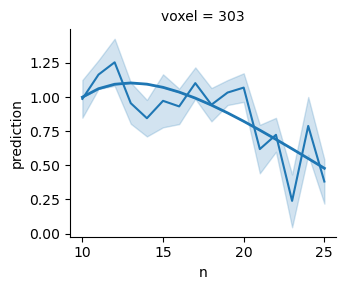

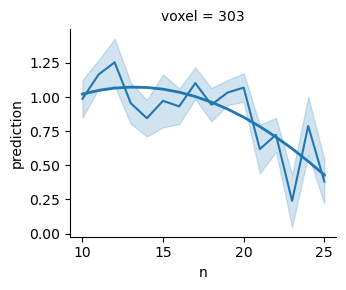

In [30]:
plot_prf_predictions('01', bids_folder=bids_folder, voxels=[303,], range_n='narrow')
plot_prf_predictions('01', bids_folder=bids_folder, voxels=[303,], range_n='narrow', gaussian=True)

In [31]:
df[mask][('lognormal',)].loc['01']

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_98575/3167065639.py", line 1, in <module>
    df[mask][('lognormal',)].loc['01']
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/indexing.py", line 1153, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/indexing.py", line 1393, in _getitem_axis
    return self._get_label(key, axis=axis)
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/indexing.py", line 1343, in _get_label
    return self.obj.xs(label, axis=axis)
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/generic.py", line 4228, in xs
    loc, new_index = index._get_loc_level(key, level=0)

In [ ]:
from scipy import optimize

[10.06897582  1.20904566 -0.12288541]


(0.0, 1.35)

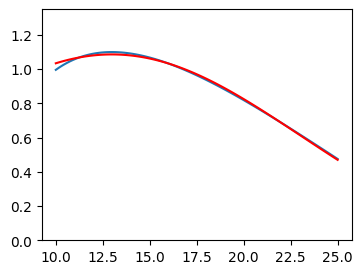

In [ ]:
plt.figure(figsize=(4,3))
xxx = np.linspace(10,25,100)
model = LogGaussianPRF(parameterisation='mode_fwhm_natural')
yyy = model.predict(xxx, parameters=pd.DataFrame(data=[[12.98,60.29,5.55,-4.45],], columns=['mode', 'fwhm', 'amplitude', 'baseline']) ).values.flatten()
plt.plot(xxx, yyy)
#plt.plot(xxx, model.predict(xxx, parameters=pd.DataFrame(data=[[12.5,33,1,-0.7],], columns=['mode', 'fwhm', 'amplitude', 'baseline']) ) )
def objf(x):
    σ, a, b = x
    zzz = b + a*np.exp(-.5*((xxx-12.98)/σ)**2)
    r = ((zzz-yyy)**2).mean()
    #print(x,r)
    return r
res = optimize.minimize(objf, x0=[10, 1, -.7], bounds=[(0.,None), (0.,None), (None,None)])
_σ, _a, _b = res.x
print(res.x)
plt.plot(xxx, _b + _a*np.exp(-.5*((xxx-12.98)/_σ)**2), c='r')
#plt.plot(xxx, -.7 + 1*np.exp(-.5*((xxx-12.5)/10)**2), ls='--')
plt.ylim(0,1.35)

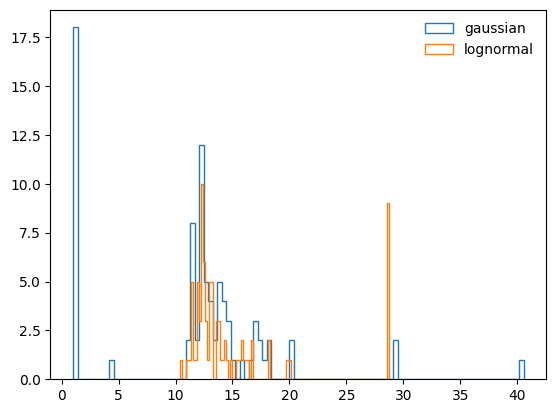

In [ ]:
mask = (df[[('gaussian', 'cvr2', 'wide'), ('gaussian', 'cvr2', 'narrow')]].mean(1) > 0.01)
#mask &= (df[('gaussian', 'mode', 'narrow')] >= 10)
plt.hist( df[mask]['gaussian', 'mode', 'narrow'], histtype='step', bins=100, label='gaussian');
plt.hist( df[mask]['lognormal', 'mode', 'narrow'], histtype='step', bins=100, label='lognormal');
plt.legend();

In [25]:
for c in df['mode'].columns:

    mode = df[('mode', c)]
    fwhm = df[('fwhm', c)]

    df[('log_sigma', c)] = 1./(np.sqrt(2.*np.log(2.))) * np.arcsinh(fwhm/(mode*2.))
    df[('log(mode)', c)] = np.log(mode)

/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/jq/_79_qpxx3vd0thkqqmw37l1c0000gn/T/ipykernel_25285/267291279.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tmp = df.stack('range_n')


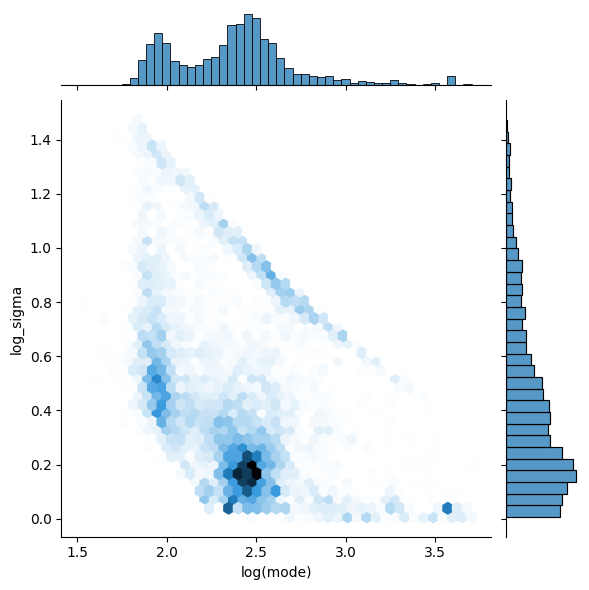

In [26]:
tmp = df.stack('range_n')
tmp = tmp[tmp.cvr2 > 0.01]
sns.jointplot(x='log(mode)', y='log_sigma', data=tmp.reset_index(), kind='hex')